In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 32
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [4]:
## Resample training data
#resample_data(train_dir)
#resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'inceptionv3.1.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
63/63 [==============================] - 16s 239ms/step
Epoch 1 - Validation Loss: 4.6582, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 1: val_loss improved from inf to 4.65822, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 177s - loss: 5.1806 - acc: 0.1346 - val_loss: 4.6582 - val_acc: 0.1112 - lr: 1.0000e-04 - 177s/epoch - 2s/step
Epoch 2/1000
63/63 [==============================] - 14s 221ms/step
Epoch 2 - Validation Loss: 3.9082, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 2: val_loss improved from 4.65822 to 3.90820, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 155s - loss: 4.2352 - acc: 0.1389 - val_loss: 3.9082 - val_acc: 0.1112 - lr: 1.0000e-04 - 155s/epoch - 1s/step
Epoch 3/1000
63/63 [==============================] - 14s 221ms/step
Epoch 3 - Validation Loss: 3.4002, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 3: val_loss improved from 3.90820 to 3.40016, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 3.6088 - acc: 0.1334 - val_loss: 3.4002 - val_acc: 0.1112 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 4/1000
63/63 [==============================] - 14s 221ms/step
Epoch 4 - Validation Loss: 3.0536, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 4: val_loss improved from 3.40016 to 3.05363, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 3.1858 - acc: 0.1429 - val_loss: 3.0536 - val_acc: 0.1112 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 5/1000
63/63 [==============================] - 14s 221ms/step
Epoch 5 - Validation Loss: 2.8190, Validation Accuracy: 0.1172, Validation Precision: 0.2795

Epoch 5: val_loss improved from 3.05363 to 2.81897, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.9029 - acc: 0.1406 - val_loss: 2.8190 - val_acc: 0.1172 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 6/1000
63/63 [==============================] - 14s 221ms/step
Epoch 6 - Validation Loss: 2.6536, Validation Accuracy: 0.1147, Validation Precision: 0.0601

Epoch 6: val_loss improved from 2.81897 to 2.65357, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.7104 - acc: 0.1440 - val_loss: 2.6536 - val_acc: 0.1147 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 7/1000
63/63 [==============================] - 14s 221ms/step
Epoch 7 - Validation Loss: 2.5294, Validation Accuracy: 0.1122, Validation Precision: 0.0466

Epoch 7: val_loss improved from 2.65357 to 2.52937, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.5717 - acc: 0.1391 - val_loss: 2.5294 - val_acc: 0.1122 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 8/1000
63/63 [==============================] - 14s 221ms/step
Epoch 8 - Validation Loss: 2.4335, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 8: val_loss improved from 2.52937 to 2.43346, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.4677 - acc: 0.1414 - val_loss: 2.4335 - val_acc: 0.1112 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 9/1000
63/63 [==============================] - 14s 219ms/step
Epoch 9 - Validation Loss: 2.3658, Validation Accuracy: 0.1142, Validation Precision: 0.0456

Epoch 9: val_loss improved from 2.43346 to 2.36583, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 133s - loss: 2.3855 - acc: 0.1320 - val_loss: 2.3658 - val_acc: 0.1142 - lr: 1.0000e-04 - 133s/epoch - 1s/step
Epoch 10/1000
63/63 [==============================] - 14s 220ms/step
Epoch 10 - Validation Loss: 2.3078, Validation Accuracy: 0.1122, Validation Precision: 0.0398

Epoch 10: val_loss improved from 2.36583 to 2.30783, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 132s - loss: 2.3199 - acc: 0.1463 - val_loss: 2.3078 - val_acc: 0.1122 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 11/1000
63/63 [==============================] - 14s 220ms/step
Epoch 11 - Validation Loss: 2.2618, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 11: val_loss improved from 2.30783 to 2.26177, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 128s - loss: 2.2662 - acc: 0.1449 - val_loss: 2.2618 - val_acc: 0.1112 - lr: 1.0000e-04 - 128s/epoch - 1s/step
Epoch 12/1000
63/63 [==============================] - 14s 221ms/step
Epoch 12 - Validation Loss: 2.2214, Validation Accuracy: 0.1142, Validation Precision: 0.0399

Epoch 12: val_loss improved from 2.26177 to 2.22142, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.2258 - acc: 0.1449 - val_loss: 2.2214 - val_acc: 0.1142 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 13/1000
63/63 [==============================] - 14s 221ms/step
Epoch 13 - Validation Loss: 2.1479, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 13: val_loss improved from 2.22142 to 2.14790, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 128s - loss: 2.1906 - acc: 0.1400 - val_loss: 2.1479 - val_acc: 0.1112 - lr: 1.0000e-04 - 128s/epoch - 1s/step
Epoch 14/1000
63/63 [==============================] - 14s 221ms/step
Epoch 14 - Validation Loss: 2.1531, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 14: val_loss did not improve from 2.14790
110/110 - 129s - loss: 2.1643 - acc: 0.1389 - val_loss: 2.1531 - val_acc: 0.1112 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 15 - Validation Loss: 2.1305, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 15: val_loss improved from 2.14790 to 2.13055, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.1374 - acc: 0.1400 - val_loss: 2.1305 - val_acc: 0.1112 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 16/1000
63/63 [==============================] - 14s 221ms/step
Epoch 16 - Validation Loss: 2.1059, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 16: val_loss improved from 2.13055 to 2.10585, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.1067 - acc: 0.1483 - val_loss: 2.1059 - val_acc: 0.1112 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 17/1000
63/63 [==============================] - 14s 220ms/step
Epoch 17 - Validation Loss: 2.0853, Validation Accuracy: 0.1112, Validation Precision: 0.0124

Epoch 17: val_loss improved from 2.10585 to 2.08533, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 128s - loss: 2.0872 - acc: 0.1517 - val_loss: 2.0853 - val_acc: 0.1112 - lr: 1.0000e-04 - 128s/epoch - 1s/step
Epoch 18/1000
63/63 [==============================] - 14s 220ms/step
Epoch 18 - Validation Loss: 2.0849, Validation Accuracy: 0.1117, Validation Precision: 0.0290

Epoch 18: val_loss improved from 2.08533 to 2.08494, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.0717 - acc: 0.1486 - val_loss: 2.0849 - val_acc: 0.1117 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 19/1000
63/63 [==============================] - 14s 220ms/step
Epoch 19 - Validation Loss: 2.0483, Validation Accuracy: 0.1077, Validation Precision: 0.0278

Epoch 19: val_loss improved from 2.08494 to 2.04826, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.0672 - acc: 0.1451 - val_loss: 2.0483 - val_acc: 0.1077 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 20/1000
63/63 [==============================] - 14s 220ms/step
Epoch 20 - Validation Loss: 2.0103, Validation Accuracy: 0.0848, Validation Precision: 0.0242

Epoch 20: val_loss improved from 2.04826 to 2.01033, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 2.0531 - acc: 0.1414 - val_loss: 2.0103 - val_acc: 0.0848 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 21/1000
63/63 [==============================] - 14s 220ms/step
Epoch 21 - Validation Loss: 2.0500, Validation Accuracy: 0.1127, Validation Precision: 0.2892

Epoch 21: val_loss did not improve from 2.01033
110/110 - 129s - loss: 2.0508 - acc: 0.1311 - val_loss: 2.0500 - val_acc: 0.1127 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 229ms/step
Epoch 22 - Validation Loss: 2.0327, Validation Accuracy: 0.1117, Validation Precision: 0.2750

Epoch 22: val_loss did not improve from 2.01033
110/110 - 136s - loss: 2.0397 - acc: 0.1374 - val_loss: 2.0327 - val_acc: 0.1117 - lr: 1.0000e-04 - 136s/epoch - 1s/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 18s 292ms/step
Epoch 23 - Validation Loss: 2.0229, Validation Accuracy: 0.1107, Validation Precision: 0.0373

Epoch 23: val_loss did not improve from 2.01033
110/110 - 175s - loss: 2.0315 - acc: 0.1374 - val_loss: 2.0229 - val_acc: 0.1107 - lr: 1.0000e-04 - 175s/epoch - 2s/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 224ms/step
Epoch 24 - Validation Loss: 2.0202, Validation Accuracy: 0.1112, Validation Precision: 0.0306

Epoch 24: val_loss did not improve from 2.01033
110/110 - 156s - loss: 2.0255 - acc: 0.1311 - val_loss: 2.0202 - val_acc: 0.1112 - lr: 1.0000e-04 - 156s/epoch - 1s/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 25 - Validation Loss: 2.0197, Validation Accuracy: 0.1112, Validation Precision: 0.0322

Epoch 25: val_loss did not improve from 2.01033
110/110 - 129s - loss: 2.0142 - acc: 0.1357 - val_loss: 2.0197 - val_acc: 0.1112 - lr: 1.0000e-04 - 129s/epoch - 1s/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 26 - Validation Loss: 2.0052, Validation Accuracy: 0.1097, Validation Precision: 0.0175

Epoch 26: val_loss improved from 2.01033 to 2.00523, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 1.9945 - acc: 0.1569 - val_loss: 2.0052 - val_acc: 0.1097 - lr: 5.0000e-05 - 129s/epoch - 1s/step
Epoch 27/1000
63/63 [==============================] - 14s 220ms/step
Epoch 27 - Validation Loss: 1.9899, Validation Accuracy: 0.1117, Validation Precision: 0.0296

Epoch 27: val_loss improved from 2.00523 to 1.98988, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 128s - loss: 1.9837 - acc: 0.1643 - val_loss: 1.9899 - val_acc: 0.1117 - lr: 5.0000e-05 - 128s/epoch - 1s/step
Epoch 28/1000
63/63 [==============================] - 14s 221ms/step
Epoch 28 - Validation Loss: 1.9236, Validation Accuracy: 0.0923, Validation Precision: 0.0205

Epoch 28: val_loss improved from 1.98988 to 1.92364, saving model to inceptionv3.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 129s - loss: 1.9945 - acc: 0.1597 - val_loss: 1.9236 - val_acc: 0.0923 - lr: 5.0000e-05 - 129s/epoch - 1s/step
Epoch 29/1000
63/63 [==============================] - 14s 220ms/step
Epoch 29 - Validation Loss: 1.9535, Validation Accuracy: 0.0863, Validation Precision: 0.0185

Epoch 29: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9690 - acc: 0.1686 - val_loss: 1.9535 - val_acc: 0.0863 - lr: 5.0000e-05 - 128s/epoch - 1s/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 30 - Validation Loss: 1.9392, Validation Accuracy: 0.0788, Validation Precision: 0.0199

Epoch 30: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9570 - acc: 0.1949 - val_loss: 1.9392 - val_acc: 0.0788 - lr: 5.0000e-05 - 128s/epoch - 1s/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 31 - Validation Loss: 2.0054, Validation Accuracy: 0.1107, Validation Precision: 0.0257

Epoch 31: val_loss did not improve from 1.92364
110/110 - 127s - loss: 1.9607 - acc: 0.1720 - val_loss: 2.0054 - val_acc: 0.1107 - lr: 5.0000e-05 - 127s/epoch - 1s/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 32 - Validation Loss: 1.9991, Validation Accuracy: 0.1137, Validation Precision: 0.0369

Epoch 32: val_loss did not improve from 1.92364
110/110 - 127s - loss: 1.9300 - acc: 0.2180 - val_loss: 1.9991 - val_acc: 0.1137 - lr: 5.0000e-05 - 127s/epoch - 1s/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 33 - Validation Loss: 1.9789, Validation Accuracy: 0.1117, Validation Precision: 0.0213

Epoch 33: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9410 - acc: 0.1926 - val_loss: 1.9789 - val_acc: 0.1117 - lr: 5.0000e-05 - 128s/epoch - 1s/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 34 - Validation Loss: 1.9503, Validation Accuracy: 0.1187, Validation Precision: 0.0392

Epoch 34: val_loss did not improve from 1.92364
110/110 - 129s - loss: 1.9234 - acc: 0.2343 - val_loss: 1.9503 - val_acc: 0.1187 - lr: 2.5000e-05 - 129s/epoch - 1s/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 35 - Validation Loss: 1.9621, Validation Accuracy: 0.1192, Validation Precision: 0.0487

Epoch 35: val_loss did not improve from 1.92364
110/110 - 127s - loss: 1.9170 - acc: 0.2066 - val_loss: 1.9621 - val_acc: 0.1192 - lr: 2.5000e-05 - 127s/epoch - 1s/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 36 - Validation Loss: 1.9782, Validation Accuracy: 0.1157, Validation Precision: 0.0794

Epoch 36: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9220 - acc: 0.2203 - val_loss: 1.9782 - val_acc: 0.1157 - lr: 2.5000e-05 - 128s/epoch - 1s/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 37 - Validation Loss: 1.9634, Validation Accuracy: 0.1287, Validation Precision: 0.0460

Epoch 37: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9203 - acc: 0.2069 - val_loss: 1.9634 - val_acc: 0.1287 - lr: 2.5000e-05 - 128s/epoch - 1s/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 38 - Validation Loss: 1.9713, Validation Accuracy: 0.1172, Validation Precision: 0.0413

Epoch 38: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9138 - acc: 0.2331 - val_loss: 1.9713 - val_acc: 0.1172 - lr: 2.5000e-05 - 128s/epoch - 1s/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 39 - Validation Loss: 1.9790, Validation Accuracy: 0.1162, Validation Precision: 0.0546

Epoch 39: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9071 - acc: 0.2360 - val_loss: 1.9790 - val_acc: 0.1162 - lr: 1.2500e-05 - 128s/epoch - 1s/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 40 - Validation Loss: 1.9697, Validation Accuracy: 0.1207, Validation Precision: 0.0538

Epoch 40: val_loss did not improve from 1.92364
110/110 - 129s - loss: 1.9071 - acc: 0.2363 - val_loss: 1.9697 - val_acc: 0.1207 - lr: 1.2500e-05 - 129s/epoch - 1s/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 41 - Validation Loss: 1.9435, Validation Accuracy: 0.1332, Validation Precision: 0.0365

Epoch 41: val_loss did not improve from 1.92364
110/110 - 129s - loss: 1.9123 - acc: 0.2211 - val_loss: 1.9435 - val_acc: 0.1332 - lr: 1.2500e-05 - 129s/epoch - 1s/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 42 - Validation Loss: 1.9739, Validation Accuracy: 0.1237, Validation Precision: 0.0580

Epoch 42: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9122 - acc: 0.2209 - val_loss: 1.9739 - val_acc: 0.1237 - lr: 1.2500e-05 - 128s/epoch - 1s/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 43 - Validation Loss: 1.9648, Validation Accuracy: 0.1297, Validation Precision: 0.0518

Epoch 43: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.8997 - acc: 0.2409 - val_loss: 1.9648 - val_acc: 0.1297 - lr: 1.2500e-05 - 128s/epoch - 1s/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 44 - Validation Loss: 1.9596, Validation Accuracy: 0.1332, Validation Precision: 0.0502

Epoch 44: val_loss did not improve from 1.92364
110/110 - 127s - loss: 1.8996 - acc: 0.2366 - val_loss: 1.9596 - val_acc: 0.1332 - lr: 6.2500e-06 - 127s/epoch - 1s/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 45 - Validation Loss: 1.9580, Validation Accuracy: 0.1352, Validation Precision: 0.0520

Epoch 45: val_loss did not improve from 1.92364
110/110 - 129s - loss: 1.9059 - acc: 0.2160 - val_loss: 1.9580 - val_acc: 0.1352 - lr: 6.2500e-06 - 129s/epoch - 1s/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 46 - Validation Loss: 1.9741, Validation Accuracy: 0.1222, Validation Precision: 0.0615

Epoch 46: val_loss did not improve from 1.92364
110/110 - 129s - loss: 1.9056 - acc: 0.2223 - val_loss: 1.9741 - val_acc: 0.1222 - lr: 6.2500e-06 - 129s/epoch - 1s/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 47 - Validation Loss: 1.9707, Validation Accuracy: 0.1247, Validation Precision: 0.0580

Epoch 47: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9073 - acc: 0.2294 - val_loss: 1.9707 - val_acc: 0.1247 - lr: 6.2500e-06 - 128s/epoch - 1s/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 48 - Validation Loss: 1.9632, Validation Accuracy: 0.1277, Validation Precision: 0.0531

Epoch 48: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.8971 - acc: 0.2291 - val_loss: 1.9632 - val_acc: 0.1277 - lr: 6.2500e-06 - 128s/epoch - 1s/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 49 - Validation Loss: 1.9672, Validation Accuracy: 0.1237, Validation Precision: 0.0530

Epoch 49: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9011 - acc: 0.2309 - val_loss: 1.9672 - val_acc: 0.1237 - lr: 3.1250e-06 - 128s/epoch - 1s/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 50 - Validation Loss: 1.9599, Validation Accuracy: 0.1302, Validation Precision: 0.0495

Epoch 50: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9019 - acc: 0.2260 - val_loss: 1.9599 - val_acc: 0.1302 - lr: 3.1250e-06 - 128s/epoch - 1s/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 51 - Validation Loss: 1.9636, Validation Accuracy: 0.1302, Validation Precision: 0.0547

Epoch 51: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.9035 - acc: 0.2177 - val_loss: 1.9636 - val_acc: 0.1302 - lr: 3.1250e-06 - 128s/epoch - 1s/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 221ms/step
Epoch 52 - Validation Loss: 1.9538, Validation Accuracy: 0.1342, Validation Precision: 0.0442

Epoch 52: val_loss did not improve from 1.92364
110/110 - 127s - loss: 1.8984 - acc: 0.2294 - val_loss: 1.9538 - val_acc: 0.1342 - lr: 3.1250e-06 - 127s/epoch - 1s/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 53 - Validation Loss: 1.9529, Validation Accuracy: 0.1347, Validation Precision: 0.0433

Epoch 53: val_loss did not improve from 1.92364
110/110 - 129s - loss: 1.9003 - acc: 0.2206 - val_loss: 1.9529 - val_acc: 0.1347 - lr: 3.1250e-06 - 129s/epoch - 1s/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 54 - Validation Loss: 1.9558, Validation Accuracy: 0.1347, Validation Precision: 0.0488

Epoch 54: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.8997 - acc: 0.2151 - val_loss: 1.9558 - val_acc: 0.1347 - lr: 1.5625e-06 - 128s/epoch - 1s/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 55 - Validation Loss: 1.9488, Validation Accuracy: 0.1357, Validation Precision: 0.0420

Epoch 55: val_loss did not improve from 1.92364
110/110 - 127s - loss: 1.8932 - acc: 0.2369 - val_loss: 1.9488 - val_acc: 0.1357 - lr: 1.5625e-06 - 127s/epoch - 1s/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 56 - Validation Loss: 1.9489, Validation Accuracy: 0.1362, Validation Precision: 0.0422

Epoch 56: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.8910 - acc: 0.2326 - val_loss: 1.9489 - val_acc: 0.1362 - lr: 1.5625e-06 - 128s/epoch - 1s/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 57 - Validation Loss: 1.9523, Validation Accuracy: 0.1352, Validation Precision: 0.0438

Epoch 57: val_loss did not improve from 1.92364
110/110 - 127s - loss: 1.8979 - acc: 0.2369 - val_loss: 1.9523 - val_acc: 0.1352 - lr: 1.5625e-06 - 127s/epoch - 1s/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 220ms/step
Epoch 58 - Validation Loss: 1.9484, Validation Accuracy: 0.1357, Validation Precision: 0.0205

Epoch 58: val_loss did not improve from 1.92364
110/110 - 128s - loss: 1.8984 - acc: 0.2283 - val_loss: 1.9484 - val_acc: 0.1357 - lr: 1.5625e-06 - 128s/epoch - 1s/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

63/63 [==============================] - 14s 223ms/step
Final Precision: 0.0205
Final Recall: 0.0923
Final F1 Score: 0.0335


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 [==============================] - 18s 366ms/step - loss: 1.9240 - acc: 0.1155
Test accuracy: 0.11551155149936676


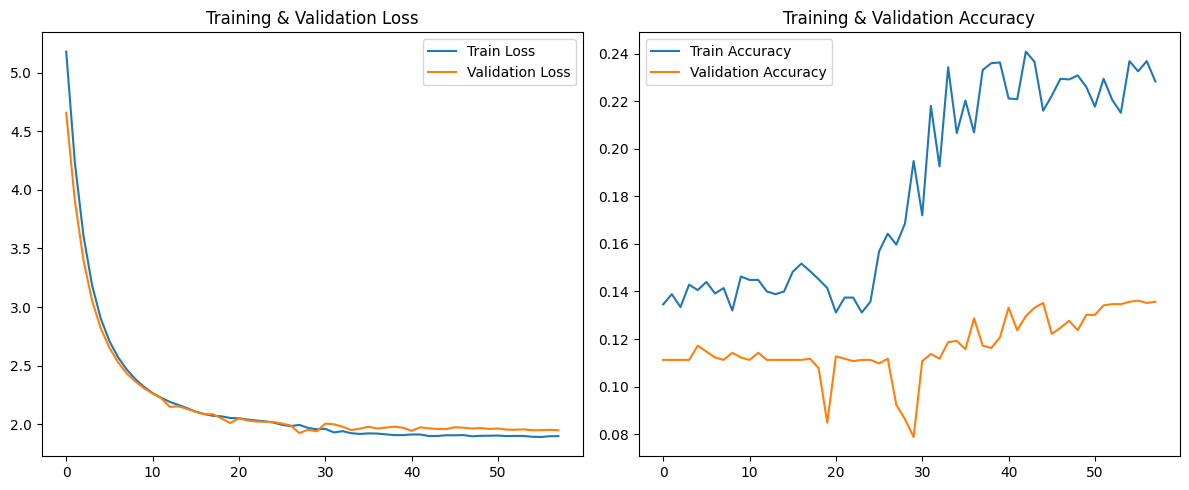

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

110/110 [==============================] - 94s 856ms/step


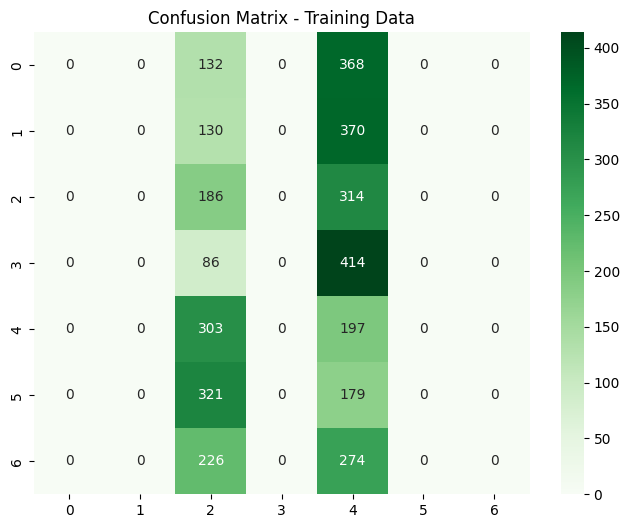

63/63 [==============================] - 14s 219ms/step


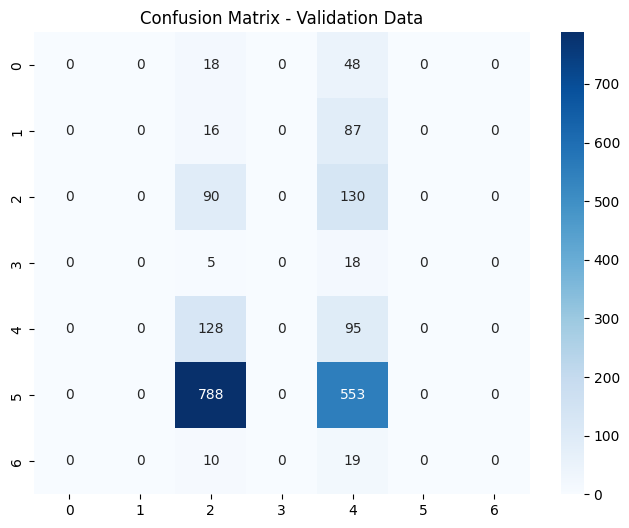

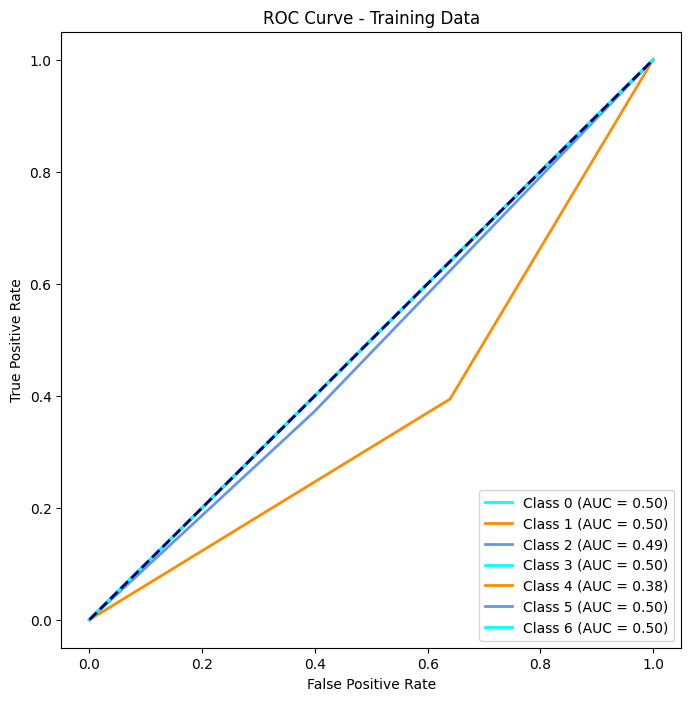

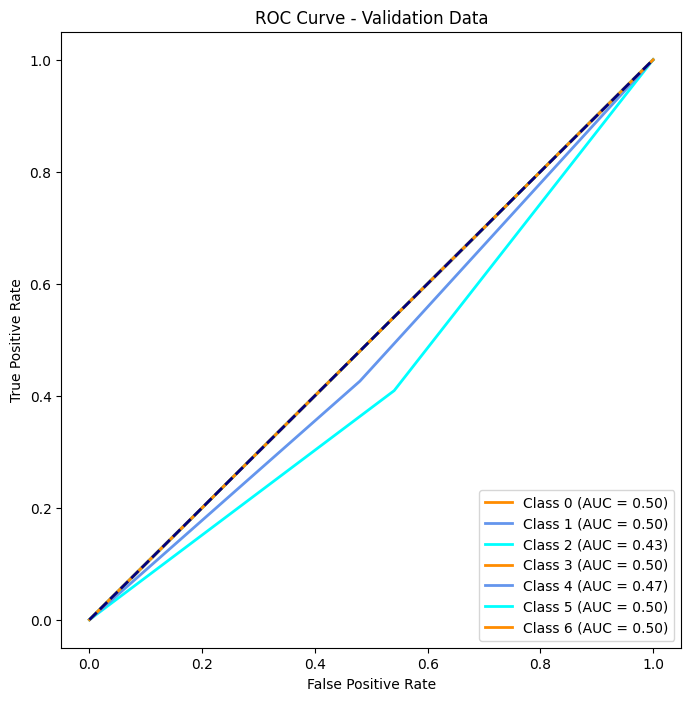

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
